In [1]:
!pip install gym shap stable-baselines3[extra] > /dev/null 2>&1

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import shap
import pickle
import gym

from sklearn.preprocessing import MinMaxScaler
from stable_baselines3 import PPO
from stable_baselines3.common.policies import obs_as_tensor
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

/usr/local/lib/python3.9/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.9/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_pa

In [3]:
train_og = pd.read_csv("/notebooks/ProcessedDataset/top001_train.csv")
test_og = pd.read_csv("/notebooks/ProcessedDataset/top001_test.csv")

train_enc = pd.read_csv("/notebooks/FinalDataset/top001_train_encoded.csv")
test_enc = pd.read_csv("/notebooks/FinalDataset/top001_test_encoded.csv")

x_train = train_enc.drop('attack_cat', axis=1)
y_train = train_enc['attack_cat']

x_train_og = train_og.drop('attack_cat', axis=1)
y_train_og = train_og['attack_cat']

x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_train_og, y_train_og = shuffle(x_train_og, y_train_og, random_state=42)

model = PPO.load("/notebooks/Models/RL/RL_001_Balanced.zip", device="cpu")

target_names = ["Analysis", "Backdoors", "DoS", "Exploits", "Fuzzers", 
                "Generic", "Reconnaissance", "Shellcode", "Worms"]

You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.


In [4]:
def rl_prediction(state):
    obs = obs_as_tensor(state, model.policy.device)
    dis = model.policy.get_distribution(obs)
    probs = dis.distribution.probs
    probs_np = probs.detach().numpy()
    return probs_np 
    res, _ = model.predict(state, deterministic=True)
    return res

with open("/notebooks/Utils/SHAP_explainer.pkl", "rb") as file:
    SHAP_explainer = pickle.load(file)
    
nsamples = 5_000
x_samples = pd.read_csv(f"/notebooks/Utils/x_samples_{nsamples}.csv")
y_samples = pd.read_csv(f"/notebooks/Utils/y_samples_{nsamples}.csv")

with open(f"/notebooks/Utils/shap_values_{nsamples}.pkl", "rb") as file:
    shap_values = pickle.load(file)

## Disaggregated class features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


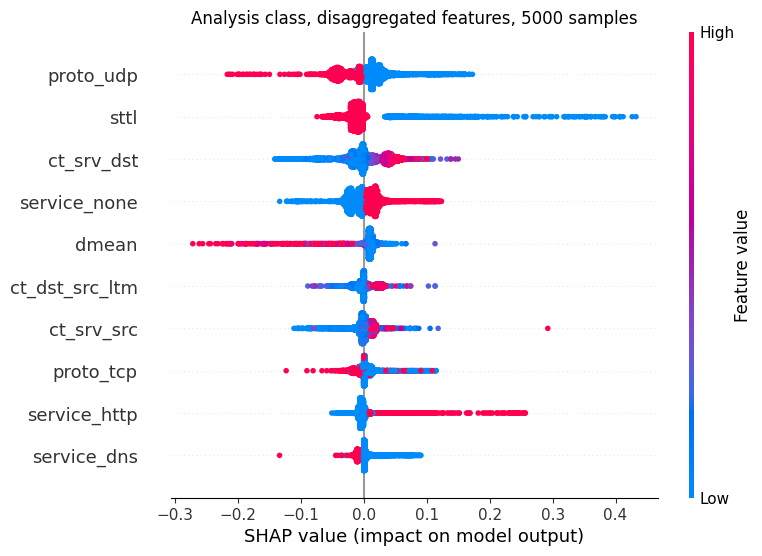

In [5]:
target_class = "Analysis"

target_class_i = target_names.index(target_class)
plt.figure()
shap.summary_plot(shap_values[target_class_i],
                  x_samples,
                  max_display=10,
                  plot_type="dot",
                  show=False)
plt.title(f"{target_names[target_class_i]} class, disaggregated features, {nsamples} samples")
plt.show()

## Numerical column avg shap_value by range

~ ct_srv_dst ~
≥ 1.00 & < 16.25: -0.014101498359746636
≥ 16.25 & < 31.50: 0.03340027141487018
≥ 31.50 & < 46.75: 0.04850244047133395
≥ 46.75 & ≤ 62.00: 0.05658383669182777


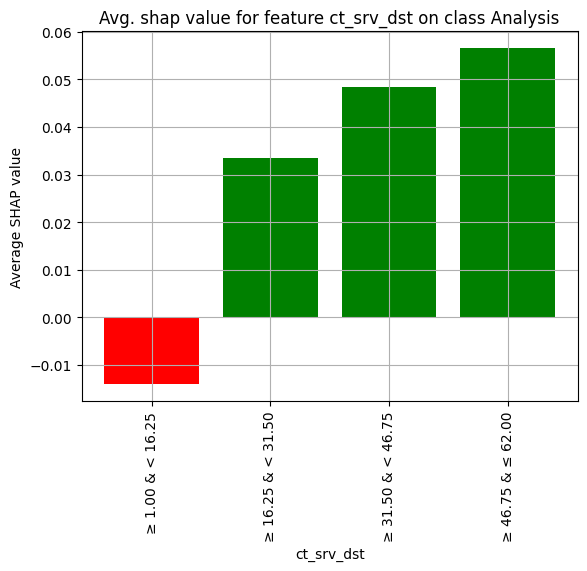

In [7]:
target_class = "Analysis"
target_class_i = target_names.index(target_class)

target_feature = "ct_srv_dst"
n_intervals = 4

intervals = np.linspace(x_train[target_feature].min(), x_train[target_feature].max(), n_intervals + 1 )
intervals_og = np.linspace(x_train_og[target_feature].min(), x_train_og[target_feature].max(), n_intervals + 1)

feature_values = x_samples[[target_feature]]

avg_shap_arr = []
x_ticks = []

print(f"~ {target_feature} ~")
for i in range(len(intervals)-1):
    
    # Creación de la máscara y de la etiqueta correspondiente al intervalo
    if i == (len(intervals)-2):
        mask = (feature_values[:] >= intervals[i]) & (feature_values[:] <= intervals[i+1])
        x_ticks.append(f"≥ {intervals_og[i]:.2f} & ≤ {intervals_og[i+1]:.2f}")
    else:
        mask = (feature_values[:] >= intervals[i]) & (feature_values[:] < intervals[i+1])
        x_ticks.append(f"≥ {intervals_og[i]:.2f} & < {intervals_og[i+1]:.2f}")
    
    # Partición de los valores de SHAP correspondientes a los valores que cumplen el rango de la iteración
    data_slice = shap_values[target_class_i][mask[target_feature].values, x_samples.columns.tolist().index(target_feature)]
    
    # El data_slice puede estar vacío si no existen valores de característica en un rango
    # En ese caso, se considera la media del valor de SHAP como 0
    avg_shap = np.nanmean(data_slice) if len(data_slice) > 0 else 0
    avg_shap_arr.append(avg_shap)
    print(f"{x_ticks[i]}: {avg_shap}")

# Idealmente convertir en una función que devuelva 'x_ticks' y 'avg_shap_arr'

# Realiza un plot de barras usando 'x_ticks' y 'avg_shap_arr'
# Para intervalos muy grandes, girar más las etiquetas
plt.bar(x_ticks, avg_shap_arr, color=['red' if value < 0 else 'green' for value in avg_shap_arr])
plt.title(f"Avg. shap value for feature {target_feature} on class {target_class}")
plt.xlabel(f"{target_feature}")
plt.ylabel(f"Average SHAP value")
plt.xticks(rotation=90)
plt.grid()
plt.show()

## Numerical column avg shap_value by given value

In [8]:
n_intervals = 11
target_feature = 'proto_udp'
test_value = lambda x: (x >= 0) & (x <= 7)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x_train_og[[target_feature]])

feature_values = scaler.inverse_transform(x_samples[[target_feature]])
feature_values = pd.DataFrame({target_feature : feature_values.flatten()})

mask = (test_value(feature_values[:]))

data_slice = shap_values[target_class_i][mask[target_feature].values, x_samples.columns.tolist().index(target_feature)]
avg_shap = np.nanmean(data_slice) if len(data_slice) > 0 else 0
print(f'Number of shap background samples that meet the condition: {len(data_slice)}')
print(f'Avg. shap value for {target_feature} values under a condition: {avg_shap:.4f}')

Number of shap background samples that meet the condition: 2836
Avg. shap value for ct_srv_dst values under a condition: 0.0426


## Categorical/binary column avg shape value

proto_tcp on 0: 0.0071
proto_tcp on 1: -0.0080


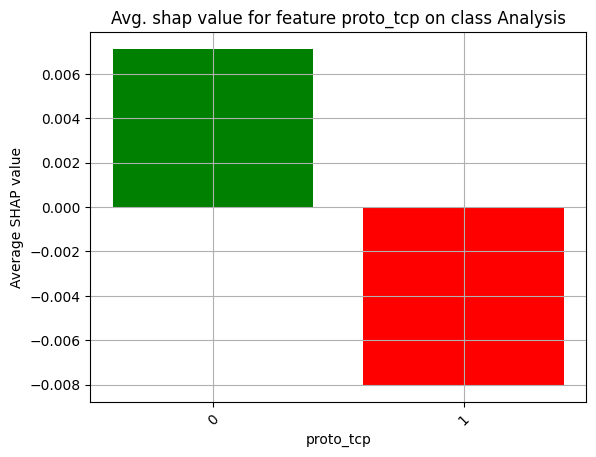

In [47]:
target_feature = 'proto_tcp'

feature_values = x_samples[[target_feature]]

avg_shap_arr = []
x_ticks = ['0', '1']

for i in range(2):
    mask = feature_values[:] == i
    data_slice = shap_values[target_class_i][mask[target_feature].values, x_samples.columns.tolist().index(target_feature)]
    avg_shap = np.nanmean(data_slice) if len(data_slice) > 0 else 0
    avg_shap_arr.append(avg_shap)
    print(f'{target_feature} on {i}: {avg_shap:.4f}')
    
plt.bar(x_ticks, avg_shap_arr, color=['red' if value < 0 else 'green' for value in avg_shap_arr])
plt.title(f"Avg. shap value for feature {target_feature} on class {target_class}")
plt.xlabel(f"{target_feature}")
plt.ylabel(f"Average SHAP value")
plt.xticks(rotation=45)
plt.grid()
plt.show()